<a href="https://colab.research.google.com/github/BowenZheng2003/Capstone-2T6/blob/main/Clustering_for_confidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
use_cuda = True

In [2]:
!pip install opensmile xgboost librosa soundfile pandas scikit-learn joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.9/324.9 kB 22.8 MB/s eta 0:00:00


In [4]:
from pydub import AudioSegment
import os
import opensmile
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import joblib
from sklearn.cluster import KMeans

In [8]:
data_folder = "/content/drive/MyDrive/Segmented Interview Information/"

### Collecting all of the segment data with features into one data structure

In [11]:
feature_cols = [
    "F0semitoneFrom27.5Hz_sma3nz_stddevNorm",  # F0_var
    "loudness_sma3_amean",                     # loudness
    "HNRdBACF_sma3nz_amean",                   # HNR
    "jitterLocal_sma3nz_amean",                # jitter
    "shimmerLocaldB_sma3nz_amean",             # shimmer
    "F0semitoneFrom27.5Hz_sma3nz_amean"        # F0_mean
]

# Collect data from all CSVs
all_dfs = []

for filename in os.listdir(data_folder):
    if filename.endswith("_all_features.csv"):
        file_path = os.path.join(data_folder, filename)
        try:
            df = pd.read_csv(file_path)
            if all(col in df.columns for col in feature_cols):
                all_dfs.append(df[["file_id", "timestamp"] + feature_cols])
            else:
                print(f"Skipping {filename} — missing required features.")
        except Exception as e:
            print(f"Failed to load {filename}: {e}")

# Combine all DataFrames
if not all_dfs:
    raise ValueError("No valid feature CSVs found in the folder.")

combined_df = pd.concat(all_dfs, ignore_index=True)

### Training clustering algorithm with all of the data
Provides the mean of each feature for each cluster

In [12]:
combined_df = pd.concat(all_dfs, ignore_index=True)

# Prepare data matrix
X = combined_df[feature_cols].fillna(0)

# Scale and cluster
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add labels back to the data
combined_df["cluster"] = cluster_labels

# Show cluster center summary
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_summary = pd.DataFrame(cluster_centers, columns=feature_cols)
cluster_summary.index.name = "cluster"

print("✅ Cluster Summary:")
print(cluster_summary)

# Save full result
output_path = os.path.join(data_folder, "combined_clusters.csv")
combined_df.to_csv(output_path, index=False)
print(f"\n📄 Cluster-labeled data saved to: {output_path}")

✅ Cluster Summary:
         F0semitoneFrom27.5Hz_sma3nz_stddevNorm  loudness_sma3_amean  \
cluster                                                                
0                                      0.340597             0.318239   
1                                      0.225934             0.484547   
2                                      0.205088             0.292992   
3                                      0.348906             0.336877   
4                                      0.234776             0.502669   

         HNRdBACF_sma3nz_amean  jitterLocal_sma3nz_amean  \
cluster                                                    
0                    -1.706040                  0.092036   
1                     4.130288                  0.039487   
2                    -2.215447                  0.061802   
3                     1.094353                  0.057639   
4                     0.544499                  0.055547   

         shimmerLocaldB_sma3nz_amean  F0semitoneFrom27.

### 3D Visualization of the clustering

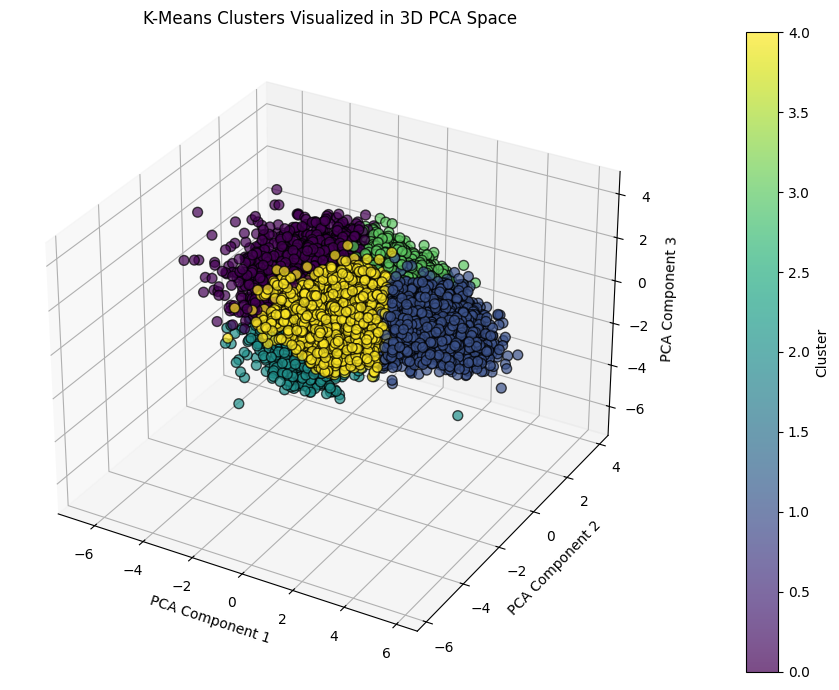

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This is needed for 3D plotting

# Reduce to 3 components for 3D plotting
X_pca_3d = PCA(n_components=3).fit_transform(X_scaled)

# 3D Scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca_3d[:, 0],
    X_pca_3d[:, 1],
    X_pca_3d[:, 2],
    c=cluster_labels,
    cmap='viridis',
    s=50,
    alpha=0.7,
    edgecolor='k'
)

ax.set_title("K-Means Clusters Visualized in 3D PCA Space")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

# Add color legend
legend = fig.colorbar(scatter, ax=ax, pad=0.1)
legend.set_label("Cluster")

plt.tight_layout()
plt.show()

### Printing the mean of each

In [18]:
combined_df.groupby("cluster")[feature_cols].mean()

,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,loudness_sma3_amean,HNRdBACF_sma3nz_amean,jitterLocal_sma3nz_amean,shimmerLocaldB_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_amean
cluster,,,,,,
0,0.340784,0.318154,-1.706149,0.092007,1.420828,21.023700
1,0.225822,0.484681,4.132264,0.039461,1.179019,31.521791
2,0.205093,0.292995,-2.215869,0.061819,1.311822,18.221277
3,0.348672,0.337212,1.100578,0.057615,1.226886,25.912197
4,0.234711,0.502685,0.543861,0.055550,1.419397,23.555195


### Clustering label generated by an LLM based on the mean values of the extracted features

In [19]:
# Example cluster labels
cluster_labels = {
    0: "Low Confidence (Tense)",
    1: "High Confidence (Expressive)",
    2: "Very Low Confidence (Flat, Pause)",
    3: "Moderate Confidence",
    4: "High Confidence (Calm)"
}

### Saving the trained model to google drive for future use

In [20]:
import joblib

# Save DataFrame with cluster labels
combined_df["confidence_label"] = combined_df["cluster"].map(cluster_labels)
combined_df.to_csv("/content/drive/MyDrive/Segmented Interview Information/Saved Model/confidence_segments.csv", index=False)

# Save the trained scaler
joblib.dump(scaler, "/content/drive/MyDrive/Segmented Interview Information/Saved Model/confidence_scaler.pkl")

# Save the trained KMeans model
joblib.dump(kmeans, "/content/drive/MyDrive/Segmented Interview Information/Saved Model/kmeans_model.pkl")

# Optional: save cluster center summary
cluster_summary.to_csv("/content/drive/MyDrive/Segmented Interview Information/Saved Model/kmeans_cluster_summary.csv")

### Testing the model with a foreign interview

In [21]:
audio = AudioSegment.from_wav("/content/sample_data/OSR_us_000_0030_8k.wav")  # Replace with your file path
segment_duration_ms = 3000
step_size = 1500  # 50% overlap

In [24]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals
)

### Preprocessing the new interview

In [25]:
segments = []
file_id = "new_audio"

for i in range(0, len(audio) - segment_duration_ms + 1, step_size):
    segment = audio[i:i + segment_duration_ms]
    segment_path = f"/tmp/{file_id}_segment_{i}.wav"
    segment.export(segment_path, format="wav")

    # Extract all features with OpenSMILE
    features_df = smile.process_file(segment_path).reset_index(drop=True).round(3)
    features = features_df.to_dict("records")[0]
    os.remove(segment_path)

    # Timestamp
    start_sec = i // 1000
    end_sec = (i + segment_duration_ms) // 1000
    timestamp = f"{start_sec//60:02d}:{start_sec%60:02d} - {end_sec//60:02d}:{end_sec%60:02d}"

    # Extract the same features used in training
    feature_row = {
        "file_id": file_id,
        "timestamp": timestamp,
        "F0semitoneFrom27.5Hz_sma3nz_stddevNorm": features.get("F0semitoneFrom27.5Hz_sma3nz_stddevNorm"),
        "loudness_sma3_amean": features.get("loudness_sma3_amean"),
        "HNRdBACF_sma3nz_amean": features.get("HNRdBACF_sma3nz_amean"),
        "jitterLocal_sma3nz_amean": features.get("jitterLocal_sma3nz_amean"),
        "shimmerLocaldB_sma3nz_amean": features.get("shimmerLocaldB_sma3nz_amean"),
        "F0semitoneFrom27.5Hz_sma3nz_amean": features.get("F0semitoneFrom27.5Hz_sma3nz_amean")
    }

    segments.append(feature_row)

### Generate labels for the segments of the new interview

In [28]:
# Create DataFrame
df_test = pd.DataFrame(segments)

# Select feature columns (same as training)
feature_cols = [
    "F0semitoneFrom27.5Hz_sma3nz_stddevNorm",
    "loudness_sma3_amean",
    "HNRdBACF_sma3nz_amean",
    "jitterLocal_sma3nz_amean",
    "shimmerLocaldB_sma3nz_amean",
    "F0semitoneFrom27.5Hz_sma3nz_amean"
]

# Scale and predict cluster
X_test = df_test[feature_cols].fillna(0)
X_test_scaled = scaler.transform(X_test)
cluster_preds = kmeans.predict(X_test_scaled)

# Assign clusters and labels
df_test["cluster"] = cluster_preds
df_test["confidence_label"] = df_test["cluster"].map(cluster_labels)

# Show full results
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 0)  # Don't wrap lines

print(df_test[["timestamp", "cluster", "confidence_label"]])

        timestamp  cluster                   confidence_label
0   00:00 - 00:03        1       High Confidence (Expressive)
1   00:01 - 00:04        1       High Confidence (Expressive)
2   00:03 - 00:06        1       High Confidence (Expressive)
3   00:04 - 00:07        1       High Confidence (Expressive)
4   00:06 - 00:09        1       High Confidence (Expressive)
5   00:07 - 00:10        1       High Confidence (Expressive)
6   00:09 - 00:12        1       High Confidence (Expressive)
7   00:10 - 00:13        1       High Confidence (Expressive)
8   00:12 - 00:15        1       High Confidence (Expressive)
9   00:13 - 00:16        1       High Confidence (Expressive)
10  00:15 - 00:18        1       High Confidence (Expressive)
11  00:16 - 00:19        1       High Confidence (Expressive)
12  00:18 - 00:21        1       High Confidence (Expressive)
13  00:19 - 00:22        1       High Confidence (Expressive)
14  00:21 - 00:24        1       High Confidence (Expressive)
15  00:2

### Load the model from google drive and test a new interview with it
Need to run the segmenting for the new interview above for this code block to work.

In [36]:
# Load data and models
df_new = pd.DataFrame(segments)
scaler_new = joblib.load("/content/drive/MyDrive/ECE496 Audio Models/confidence_scaler.pkl")
kmeans_new = joblib.load("/content/drive/MyDrive/ECE496 Audio Models/kmeans_model.pkl")

feature_cols = [
    "F0semitoneFrom27.5Hz_sma3nz_stddevNorm",
    "loudness_sma3_amean",
    "HNRdBACF_sma3nz_amean",
    "jitterLocal_sma3nz_amean",
    "shimmerLocaldB_sma3nz_amean",
    "F0semitoneFrom27.5Hz_sma3nz_amean"
]

# Re-scale and re-predict cluster labels
X_new = df_test[feature_cols].fillna(0)
X_new_scaled = scaler.transform(X_new)
predicted_clusters = kmeans.predict(X_test_scaled)

# Map clusters to confidence labels
cluster_labels = {
    0: "Low Confidence (Tense)",
    1: "High Confidence (Expressive)",
    2: "Very Low Confidence (Flat, Pause)",
    3: "Moderate Confidence",
    4: "High Confidence (Calm)"
}

# Add predictions to DataFrame
df_new["reclustered"] = predicted_clusters
df_new["reconf_label"] = df_new["reclustered"].map(cluster_labels)

# Show the result
print(df_new[["timestamp", "reclustered", "reconf_label"]])


        timestamp  reclustered                       reconf_label
0   00:00 - 00:03            1       High Confidence (Expressive)
1   00:01 - 00:04            1       High Confidence (Expressive)
2   00:03 - 00:06            1       High Confidence (Expressive)
3   00:04 - 00:07            1       High Confidence (Expressive)
4   00:06 - 00:09            1       High Confidence (Expressive)
5   00:07 - 00:10            1       High Confidence (Expressive)
6   00:09 - 00:12            1       High Confidence (Expressive)
7   00:10 - 00:13            1       High Confidence (Expressive)
8   00:12 - 00:15            1       High Confidence (Expressive)
9   00:13 - 00:16            1       High Confidence (Expressive)
10  00:15 - 00:18            1       High Confidence (Expressive)
11  00:16 - 00:19            1       High Confidence (Expressive)
12  00:18 - 00:21            1       High Confidence (Expressive)
13  00:19 - 00:22            1       High Confidence (Expressive)
14  00:21 